# Time Series Forecasting on NYC_Taxi

w MLFlow

- Objectives
  - Leverage ML FLow to build some time series models

- Simple Forecast of aggregate daily data to start
- Later will need to look at splitting out the datasets into different spots

In [1]:
import os
from pyspark.sql import SparkSession
packages="""io.delta:delta-core_2.12:1.0.0,org.apache.hadoop:hadoop-aws:3.2.0"""
os.environ['PYSPARK_SUBMIT_ARGS'] = "--packages io.delta:delta-core_2.12:1.0.0,org.apache.hadoop:hadoop-aws:3.2.0 pyspark-shell"

In [2]:
spark = SparkSession \
            .builder \
            .config("spark.executor.cores", 4) \
            .config("spark.executor.memory", "4g") \
            .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
            .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
            .config("spark.master", "spark://spark-master:7077") \
            .config("spark.hadoop.fs.s3a.access.key", os.environ['MINIO_ACCESS_KEY']) \
            .config("spark.hadoop.fs.s3a.secret.key", os.environ['MINIO_SECRET_KEY']) \
            .config("spark.hadoop.fs.s3a.endpoint", "minio:9000") \
            .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
            .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
            .config("spark.hadoop.metastore.catalog.default", "hive") \
            .config("spark.sql.warehouse.dir", "s3a://storage/warehouse") \
            .config("spark.hadoop.fs.s3a.path.style.access", "true") \
            .config("spark.hadoop.fs.s3a.connection.maximum", "50") \
            .config("spark.hive.metastore.uris", "thrift://192.168.64.4:9083") \
            .appName("Jupyter Time Series") \
            .enableHiveSupport() \
            .getOrCreate()

In [5]:
# tuning settings spark.sql.shuffle.partitions to match with core settings
# not tuned for file size yet

# set to cores to increase the efficiency
spark.conf.set("spark.sql.shuffle.partitions", spark.sparkContext.defaultParallelism*4)

## faster pandas data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [6]:
## Loading out the dataset
nyc_taxi_dataset = spark.sql("SELECT * FROM processed.nyc_taxi_dataset")

In [5]:
nyc_taxi_dataset.printSchema()

root
 |-- data_source: string (nullable = true)
 |-- pickup_year: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- rate_code_id: string (nullable = true)
 |-- pickup_longitude: float (nullable = true)
 |-- pickup_latitude: float (nullable = true)
 |-- dropoff_longitude: float (nullable = true)
 |-- dropoff_latitude: float (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- ehail_fee: float (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- trip_type: int

In [7]:
from pyspark.sql import functions as F

In [8]:
## Lets do some dailies to start
daily_totals = (
    nyc_taxi_dataset
        .withColumn("pickup_date", F.to_date("pickup_datetime"))
        .select("pickup_date", "total_amount")
        .groupBy("pickup_date")
        .agg(
            F.count("total_amount").alias("total_rides"),
            F.sum("total_amount").alias("total_takings")
        )
        .sort("pickup_date")
)

In [9]:
daily_totals.printSchema()

root
 |-- pickup_date: date (nullable = true)
 |-- total_rides: long (nullable = false)
 |-- total_takings: double (nullable = true)



In [10]:
daily_totals.take(10)

[Row(pickup_date=datetime.date(2013, 8, 1), total_rides=307272, total_takings=4567414.341715002),
 Row(pickup_date=datetime.date(2013, 8, 2), total_rides=236761, total_takings=3534615.589567093),
 Row(pickup_date=datetime.date(2013, 8, 3), total_rides=226554, total_takings=3182267.26641283),
 Row(pickup_date=datetime.date(2013, 8, 4), total_rides=202310, total_takings=3073608.618903598),
 Row(pickup_date=datetime.date(2013, 8, 5), total_rides=406487, total_takings=6657712.825942375),
 Row(pickup_date=datetime.date(2013, 8, 6), total_rides=448272, total_takings=6576702.611193515),
 Row(pickup_date=datetime.date(2013, 8, 7), total_rides=465702, total_takings=6925976.081809193),
 Row(pickup_date=datetime.date(2013, 8, 8), total_rides=437214, total_takings=6515832.371952146),
 Row(pickup_date=datetime.date(2013, 8, 9), total_rides=489393, total_takings=7254375.474818595),
 Row(pickup_date=datetime.date(2013, 8, 10), total_rides=445096, total_takings=6392653.797500223)]

In [11]:
daily_totals.filter("pickup_date < '2014-07-01'").count()

334

In [12]:
### format Aug 2013 data
daily_rides_cut = (daily_totals.select(F.col("pickup_date").alias("ds"),
                   F.col("total_rides").alias("y")).filter("pickup_date < '2014-07-01'").toPandas())

## Forecasting the Dataframe

In [13]:
# credentials for storing our model artifacts
# mlflow needs these to be set whenever it is being called
os.environ['AWS_ACCESS_KEY_ID'] = os.environ.get('MINIO_ACCESS_KEY')
os.environ['AWS_SECRET_ACCESS_KEY'] = os.environ.get('MINIO_SECRET_KEY')
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://minio:9000'

In [41]:
import prophet
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import mlflow

There was an error in the hostname resolution hence switch to ip

In [70]:
#mlflow.delete_experiment(1)

In [73]:
mlflow.set_tracking_uri("http://192.168.64.21:5000/")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: http://192.168.64.21:5000/


In [79]:
### Quick test on creating experiments
from mlflow.exceptions import RestException

try:
    mlflow.create_experiment(
        name='taxi_daily_forecast'
    )
except RestException:
    print('already_created')

In [82]:
experiment = mlflow.get_experiment(15)
experiment.artifact_location

's3://mlflow/15'

In [83]:
# Build an evaluation function
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [84]:
# To save models to mlflow we need to write a python wrapper 
# to make sure that it performs as mlflow expects
import mlflow.pyfunc

class ProphetModel(mlflow.pyfunc.PythonModel):
    
    def __init__(self, model):
        
        self.model = model
        super().__init__()
        
    def load_context(self, context):
        from prophet import Prophet
        return
    
    def predict(self, context, model_input):
        future = self.model.make_future_dataframe(periods=model_input['periods'][0])
        return self.model.predict(future)

In [86]:
rolling_window = 0.1

conda_env = {
    'channels': ['conda-forge'],
    'dependencies': [{
        'pip': [
            'prophet=={0}'.format(prophet.__version__)
        ]
    }],
    "name": "prophetenv"
}

with mlflow.start_run(experiment_id=15):
    m = prophet.Prophet(daily_seasonality=True)
    m.fit(daily_rides_cut)
    
    df_cv = cross_validation(m, initial="28 days", period="7 days", horizon="14 days")
    df_p = performance_metrics(df_cv, rolling_window=rolling_window)
    
    mlflow.log_param("rolling_window", rolling_window)
    mlflow.log_metric("rmse", df_p.loc[0, "rmse"])
    mlflow.log_metric("mae", df_p.loc[0, "mae"])
    mlflow.log_metric("mape", df_p.loc[0, "mape"])
    
    print("  CV: {}".format(df_cv.head()))
    print("  Perf: {}".format(df_p.head()))
    
    mlflow.pyfunc.log_model("model", conda_env=conda_env, python_model=ProphetModel(m))
    print(
            "Logged model with URI: runs:/{run_id}/model".format(
                run_id=mlflow.active_run().info.run_id
            )
        )

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Making 42 forecasts with cutoffs between 2013-09-02 00:00:00 and 2014-06-16 00:00:00


  0%|          | 0/42 [00:00<?, ?it/s]

  CV:           ds           yhat     yhat_lower     yhat_upper       y     cutoff
0 2013-09-03  501585.281837  430785.622012  579335.646599  423109 2013-09-02
1 2013-09-04  518817.592943  447829.125053  594199.125323  454753 2013-09-02
2 2013-09-05  504761.734693  432604.695155  581197.391682  468204 2013-09-02
3 2013-09-06  495324.421080  420940.511185  570812.848236  509666 2013-09-02
4 2013-09-07  474445.011476  406010.241206  548858.065276  512373 2013-09-02
  Perf:   horizon           mse          rmse           mae      mape     mdape  \
0  2 days  2.802909e+09  52942.502951  37278.418974  0.086742  0.049990   
1  3 days  3.124219e+09  55894.709955  37167.961699  0.085093  0.047995   
2  4 days  3.170948e+09  56311.167889  37426.567206  0.081971  0.043602   
3  5 days  2.723070e+09  52183.046660  38084.927978  0.074821  0.056177   
4  6 days  1.912054e+09  43727.040544  33739.912505  0.068865  0.045557   

      smape  coverage  
0  0.078420  0.908867  
1  0.077513  0.859606  
2

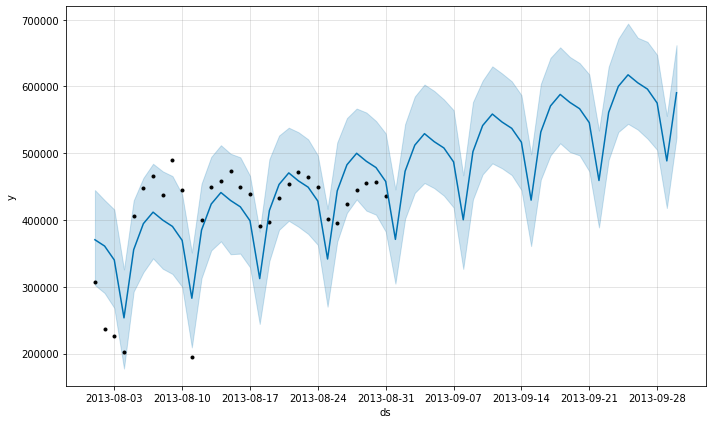

In [17]:
# Python Plots
fig1 = m.plot(forecast)

In [88]:
# testing with another timeseries forecast
from sktime.forecasting.base import ForecastingHorizon
import pandas as pd

In [117]:
from sktime.forecasting.all import *
from sktime.forecasting.model_evaluation import evaluate

forecaster = ARIMA()
cv = SlidingWindowSplitter(step_length=7, window_length=28, fh=7)
out = evaluate(forecaster, cv, daily_rides_cut['y'])   

In [116]:
for item in out.iterrows():
    #mlflow.log_param("cutoff", item['cutoff'])
    mlflow.log_metric("mape", item[1]['test_MeanAbsolutePercentageError'])

In [118]:
out

,cutoff,fit_time,len_train_window,pred_time,test_MeanAbsolutePercentageError
0,27.0,0.059019,28,0.007670,0.125106
1,34.0,0.007840,28,0.005107,0.165282
2,41.0,0.016281,28,0.005009,0.072373
3,48.0,0.007553,28,0.003701,0.002654
4,55.0,0.007120,28,0.006092,0.025837
5,62.0,0.010227,28,0.003584,0.015001
6,69.0,0.005974,28,0.003339,0.003807
7,76.0,0.006106,28,0.003293,0.042291
8,83.0,0.005166,28,0.003237,0.006497
9,90.0,0.005727,28,0.003212,0.004492
